## example

In [1]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

class CURParam:
    def __init__(self, reltol: float = 0, rankMax: int = 0, pivoting: str = 'full', nRookIter: int = 3, blockSize: int = 1):
        self.reltol = reltol           # 相对容差
        self.rankMax = rankMax         # 最大秩
        self.pivoting = pivoting       # 主元选择策略：'full'、'rook'
        self.nRookIter = nRookIter     # Rook Pivoting 的最大迭代次数
class CURDecomp:
    def __init__(self, A: np.ndarray, leftOrthogonal: bool = True, param: CURParam = CURParam(), maxIterations: int = 0):
        self.A = A.copy()
        self.leftOrthogonal = leftOrthogonal
        self.param = param
        self.maxIterations = maxIterations
        self.Iset: List[int] = list(range(A.shape[0]))
        self.Jset: List[int] = list(range(A.shape[1]))
        self.C: np.ndarray = None
        self.R: np.ndarray = None
        self.W: np.ndarray = None
        self.U: np.ndarray = None
        self.iteration_errors: List[float] = []
        self.npivot: int = 0
        self.error: float = 0.0

    def rook_pivoting(self, A: np.ndarray, k: int) -> Tuple[int, int, float]:
        max_iter = self.param.nRookIter
        rows = np.arange(k, A.shape[0])
        cols = np.arange(k, A.shape[1])
        i0, j0 = k, k
        err = abs(A[i0, j0])
        for _ in range(max_iter):
            # Find max in column
            col_abs = np.abs(A[rows, j0])
            i_rel = np.argmax(col_abs)
            i_new = rows[i_rel]
            max_col = col_abs[i_rel]

            # Find max in row
            row_abs = np.abs(A[i_new, cols])
            j_rel = np.argmax(row_abs)
            j_new = cols[j_rel]
            max_row = row_abs[j_rel]

            if i_new == i0 and j_new == j0:
                err = abs(A[i0, j0])
                break
            else:
                i0, j0 = i_new, j_new
                err = abs(A[i0, j0])
        return i0, j0, err

    def full_pivoting(self, A: np.ndarray, k: int) -> Tuple[int, int, float]:
        subA = np.abs(A[k:, k:])
        p = np.argmax(subA)
        i_rel, j_rel = np.unravel_index(p, subA.shape)
        i0 = i_rel + k
        j0 = j_rel + k
        err = abs(A[i0, j0])
        return i0, j0, err

    def calculate(self):
        A = self.A.copy()
        n_rows, n_cols = A.shape
        reltol = self.param.reltol
        rankMax = self.param.rankMax
        pivoting = self.param.pivoting

        self.npivot = min(n_rows, n_cols)
        if reltol == 0:
            reltol = self.npivot * np.finfo(A.dtype).eps

        max_error = 0.0
        if rankMax > 0 and rankMax < self.npivot:
            self.npivot = rankMax

        k = 0
        while k < self.npivot and (self.maxIterations == 0 or k < self.maxIterations):
            # 主元选择
            if pivoting == 'rook':
                i0, j0, err = self.rook_pivoting(A, k)
            else:  # 'full' or default
                i0, j0, err = self.full_pivoting(A, k)
            if k > 0 and err < reltol * max_error:
                self.npivot = k
                break
            else:
                max_error = max(max_error, err)

            # Swap rows and columns
            self.Iset[k], self.Iset[i0] = self.Iset[i0], self.Iset[k]
            self.Jset[k], self.Jset[j0] = self.Jset[j0], self.Jset[k]
            A[[k, i0], :] = A[[i0, k], :]
            A[:, [k, j0]] = A[:, [j0, k]]

            # Update the error, i.e., make Gaussian elimination
            rows = slice(k + 1, A.shape[0])
            cols = slice(k + 1, A.shape[1])

            if k + 1 < A.shape[0] and self.leftOrthogonal:
                A[rows, k] /= A[k, k]
            elif k + 1 < A.shape[1] and not self.leftOrthogonal:
                A[k, cols] /= A[k, k]

            if k + 1 < self.npivot:
                if self.leftOrthogonal:
                    A[rows, cols] -= np.outer(A[rows, k], A[k, cols])
                else:
                    A[rows, cols] -= np.outer(A[k, rows], A[k, cols])
                    
            # Compute residual and record
            residual = np.linalg.norm(A[k + 1:, k + 1:], ord='fro')
            self.iteration_errors.append(residual)
            k += 1

        if self.npivot < min(n_rows, n_cols):
            self.error = np.max(np.abs(A[self.npivot:, self.npivot:]))
        else:
            self.error = 0.0
        print(f"pivot value: {self.A[self.Iset[:self.npivot], self.Jset[:self.npivot]]}")
        # Compute C, R, W, U
        self.C = self.A[:, self.Jset[:self.npivot]]
        self.R = self.A[self.Iset[:self.npivot], :]
        print(f"self.Iset[:self.npivot], self.Jset[:self.npivot]", self.Iset[:self.npivot], self.Jset[:self.npivot])
        self.W = self.A[np.ix_(self.Iset[:self.npivot], self.Jset[:self.npivot])]
        # Compute U as the pseudoinverse of W
        self.U = np.linalg.pinv(self.W)

    def reconstruct(self) -> np.ndarray:
        return self.C @ self.U @ self.R
    def Check_C(self) -> np.ndarray:
        return self.C

    def Check_R(self) -> np.ndarray:
        return self.R
    

## 測試用矩陣A

In [2]:
import numpy as np
np.random.seed(996)
def generate_tensor(m, n, zero_prob):
    # 先生成一個 m x n 的隨機矩陣，元素均來自 [0, 1) 的均勻分布
    tensor = np.random.rand(m, n)
    # 再生成一個同型態的 mask，每個位置以 zero_prob 機率為 True
    mask = np.random.rand(m, n) < zero_prob
    # 把 mask 為 True 的位置設為 0
    tensor[mask] = 0
    return tensor


m, n, zero_prob = 32, 32, 0.3  # 例如 5x5 矩陣，每個元素 30% 機率為 0
A_test = generate_tensor(m, n, zero_prob)
print(A_test.shape)

(32, 32)


pivot value: [0.99861061 0.99860556 0.94578519 0.96166641 0.66969062 0.89628568
 0.79524807 0.87419623 0.05647555 0.13453478 0.         0.66351612
 0.04122582 0.87985122 0.87241194 0.81277225 0.58081135 0.
 0.16357888 0.         0.89171857 0.         0.97598825 0.71497015
 0.80887625 0.83003221 0.         0.52334423 0.         0.20251093
 0.82996122 0.        ]
self.Iset[:self.npivot], self.Jset[:self.npivot] [13, 21, 1, 25, 16, 30, 19, 14, 12, 20, 5, 11, 7, 17, 29, 26, 18, 6, 27, 10, 22, 9, 24, 23, 3, 0, 15, 28, 8, 2, 4, 31] [9, 1, 8, 21, 12, 24, 13, 6, 14, 0, 27, 28, 2, 15, 22, 10, 16, 31, 11, 26, 30, 18, 7, 19, 29, 25, 23, 17, 5, 3, 4, 20]


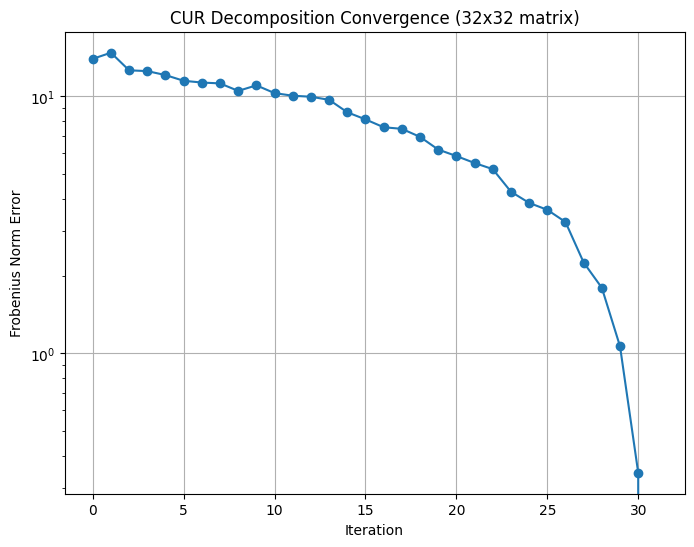


[INFO] Results for 32x32 matrix:
Reconstruction error: 0.0
CUR rank: 32
Iteration errors: [13.968329756673912, 14.750823571882277, 12.600551510903717, 12.513202729334692, 12.075581863238584, 11.474691513946732, 11.295452988319186, 11.209257235658315, 10.481198268191976, 11.015149544174575, 10.275564664844213, 10.038528079413553, 9.947601189257265, 9.676042182524455, 8.655638146721403, 8.121863710219975, 7.570475980459622, 7.46357162945969, 6.944889523684476, 6.198910373228241, 5.850777199768342, 5.497272526757655, 5.203165268847656, 4.251943216729185, 3.8464358839470547, 3.615305358019811, 3.2416843728883626, 2.255811037543254, 1.798626461101107, 1.0649969190143525, 0.34369917562215635, 0.0]
R: (32, 32)
C: (32, 32)

Reconstruction error_c (Frobenius norm) C: 14.94660693197741

Reconstruction error_r (Frobenius norm) R: 14.825665322937958


In [3]:
# Test different matrix sizes
sizes = [(32,32)]
    
for n_rows, n_cols in sizes:
    A = generate_tensor(n_rows, n_cols, zero_prob)
    leftOrthogonal = True
    reltol = 1e-14
    rankMax = min(n_rows, n_cols)  
    pivoting = 'max'
    nRookIter = 3
    blockSize = 1
    param = CURParam(reltol, rankMax, pivoting, nRookIter, blockSize)
    maxIterations = 0
    
    cur = CURDecomp(A, leftOrthogonal, param, maxIterations)
    cur.calculate()
    # Plot iteration errors
    plt.figure(figsize=(8, 6))
    plt.semilogy(cur.iteration_errors, 'o-')
    plt.title(f'CUR Decomposition Convergence ({n_rows}x{n_cols} matrix)')
    plt.xlabel('Iteration')
    plt.ylabel('Frobenius Norm Error')
    plt.grid(True)
    plt.show()
    
    print(f"\n[INFO] Results for {n_rows}x{n_cols} matrix:")
    print("Reconstruction error:", cur.error)
    print("CUR rank:", cur.npivot)
    print("Iteration errors:", cur.iteration_errors)
    
mciR=cur.Check_R()
mciC=cur.Check_C()
print("R:",mciR.shape)
print("C:",mciC.shape)
error_c = np.linalg.norm(A_test - mciC)
error_r = np.linalg.norm(A_test - mciR)
print("\nReconstruction error_c (Frobenius norm) C:", error_c)
print("\nReconstruction error_r (Frobenius norm) R:", error_r)



## new version

In [4]:
from typing import List, Tuple
import numpy as np

class MCI_CUR:
    def __init__(self, A: np.ndarray, leftOrthogonal: bool = True):
        self.A = A  # 原始矩陣
        self.leftOrthogonal = leftOrthogonal  # 決定使用左正交 Schur 更新
        self.Iset: List[int] = list(range(A.shape[0]))
        self.Jset: List[int] = list(range(A.shape[1]))
        self.C: np.ndarray = None
        self.R: np.ndarray = None
        self.W: np.ndarray = None
        self.U: np.ndarray = None
        self.npivot: int = 0
        self.error_value: float = 0.0  # 這裡改名，避免與方法名稱衝突
        self.pivot_positions: List[Tuple[int, int]] = []  # 紀錄每次 pivot 在原始矩陣中的位置
        
        # 儲存各迭代步驟的誤差數據
        self.iteration_errors = []    # Trailing 子矩陣的 Frobenius 殘差
        self.recon_errors_fro = []    # 重構誤差：Frobenius norm
        self.recon_errors_inf = []    # 重構誤差：Infinity norm
        self.recon_errors_2   = []    # 重構誤差：2-Norm

    def select(self, A_work: np.ndarray, k: int) -> Tuple[int, int, float]:
        """
        在 A_work 的右下子矩陣（從第 k 行、k 列開始）中選取絕對值最大的元素，
        回傳其在 A_work 中的行、列索引及其值。
        """
        m, n_cols = A_work.shape
        sub_rows = slice(k, m)
        sub_cols = slice(k, n_cols)
        subA = np.abs(A_work[sub_rows, sub_cols])
        p = np.argmax(subA)
        i_rel, j_rel = np.unravel_index(p, subA.shape)
        i0 = i_rel + k
        j0 = j_rel + k
        pivot_val = A_work[i0, j0]
        return i0, j0, pivot_val

    def compute_error(self, pivot_rows_sorted: List[int], pivot_cols_sorted: List[int]):
        """
        根據目前的 pivot 集合，利用 CUR 分解重構矩陣，
        並計算重構誤差：
          - Frobenius norm
          - Infinity norm
          - 2-Norm
        回傳一個三元 tuple (err_fro, err_inf, err_2)
        """
        W = self.A[np.ix_(pivot_rows_sorted, pivot_cols_sorted)].copy()
        C = self.A[:, pivot_cols_sorted]
        R = self.A[pivot_rows_sorted, :]
        U = np.linalg.pinv(W)
        A_reconstructed = C @ U @ R
        err_fro = np.linalg.norm(self.A - A_reconstructed, ord='fro')
        err_inf = np.linalg.norm(self.A - A_reconstructed, ord=np.inf)
        err_2   = np.linalg.norm(self.A - A_reconstructed, ord=2)
        return err_fro, err_inf, err_2

    def calculate(self, rank: int):
        """
        進行 MCI CUR 分解，利用 select() 選取 pivot，
        並以 Schur 補矩陣更新提升精準度。
        參數 rank 為欲選取的 pivot 個數（目標低秩）。
        每次迭代後透過 compute_error() 函數計算誤差指標，並記錄下來。
        """
        m, n_cols = self.A.shape
        A_work = self.A.copy()  # 工作矩陣，不影響原始 A
        Iset = list(range(m))    # 追蹤行交換順序
        Jset = list(range(n_cols))  # 追蹤列交換順序
        pivot_positions = []     # 紀錄每次選到的 pivot 在原始矩陣中的 (row, col)
        
        # 清空誤差記錄
        self.iteration_errors = []
        self.recon_errors_fro = []
        self.recon_errors_inf = []
        self.recon_errors_2   = []

        for k in range(rank):
            i0, j0, pivot_val = self.select(A_work, k)
            if np.abs(pivot_val) < 1e-12:
                print(f"Iteration {k}: Pivot value too small ({pivot_val}), stopping iteration.")
                break

            # 記錄當前 pivot 位置（根據目前 Iset 與 Jset）
            pivot_positions.append((Iset[i0], Jset[j0]))

            # 將 pivot 交換至對角線位置 (k, k)
            A_work[[k, i0], :] = A_work[[i0, k], :]
            Iset[k], Iset[i0] = Iset[i0], Iset[k]
            A_work[:, [k, j0]] = A_work[:, [j0, k]]
            Jset[k], Jset[j0] = Jset[j0], Jset[k]

            # Schur 補矩陣更新
            if self.leftOrthogonal:
                A_work[k+1:m, k] = A_work[k+1:m, k] / A_work[k, k]
                A_work[k+1:m, k+1:n_cols] -= np.outer(A_work[k+1:m, k], A_work[k, k+1:n_cols])
            else:
                A_work[k, k+1:n_cols] = A_work[k, k+1:n_cols] / A_work[k, k]
                A_work[k+1:m, k+1:n_cols] -= np.outer(A_work[k+1:m, k], A_work[k, k+1:n_cols])
            
            # 計算 trailing 子矩陣的 Frobenius 殘差（作為迭代誤差之一）
            if k < min(m, n_cols) - 1:
                trailing_residual = np.linalg.norm(A_work[k+1:, k+1:], ord='fro')
            else:
                trailing_residual = 0.0
            self.iteration_errors.append(trailing_residual)
            print(f"Iteration {k+1}: Trailing Residual = {trailing_residual}")

            # 利用目前的 pivot 集合計算重構誤差
            current_pivots = k + 1
            pivot_rows = Iset[:current_pivots]
            pivot_cols = Jset[:current_pivots]
            pivot_rows_sorted = sorted(pivot_rows)
            pivot_cols_sorted = sorted(pivot_cols)
            err_fro, err_inf, err_2 = self.compute_error(pivot_rows_sorted, pivot_cols_sorted)
            self.recon_errors_fro.append(err_fro)
            self.recon_errors_inf.append(err_inf)
            self.recon_errors_2.append(err_2)
            print(f"Iteration {k+1}: Reconstruction Error -> Frobenius: {err_fro}, Inf: {err_inf}, 2-Norm: {err_2}")

        self.npivot = len(pivot_positions)
        self.pivot_positions = pivot_positions

        # 利用最終的 pivot 位置建立完整的 CUR 分解
        pivot_rows = Iset[:self.npivot]
        pivot_cols = Jset[:self.npivot]
        pivot_rows_sorted = sorted(pivot_rows)
        pivot_cols_sorted = sorted(pivot_cols)

        self.W = self.A[np.ix_(pivot_rows_sorted, pivot_cols_sorted)].copy()
        self.C = self.A[:, pivot_cols_sorted]
        self.R = self.A[pivot_rows_sorted, :]
        self.U = np.linalg.pinv(self.W)
        

A_test shape: (32, 32)
Iteration 1: Trailing Residual = 8.542997980736333
Iteration 1: Reconstruction Error -> Frobenius: 8.542997980736333, Inf: 7.40322158819914, 2-Norm: 3.8394933176508874
Iteration 2: Trailing Residual = 8.580296437086123
Iteration 2: Reconstruction Error -> Frobenius: 8.58029643708612, Inf: 8.161377628665406, 2-Norm: 4.1903100877894115
Iteration 3: Trailing Residual = 8.111613509772125
Iteration 3: Reconstruction Error -> Frobenius: 8.111613509772127, Inf: 9.036750316058693, 2-Norm: 3.680976227067931
Iteration 4: Trailing Residual = 7.73001544715492
Iteration 4: Reconstruction Error -> Frobenius: 7.73001544715492, Inf: 8.229186001810776, 2-Norm: 3.3442907143921774
Iteration 5: Trailing Residual = 7.393765785923204
Iteration 5: Reconstruction Error -> Frobenius: 7.393765785923203, Inf: 8.122914947239645, 2-Norm: 3.0499114158766183
Iteration 6: Trailing Residual = 7.104067416654764
Iteration 6: Reconstruction Error -> Frobenius: 7.104067416654765, Inf: 8.140237340433

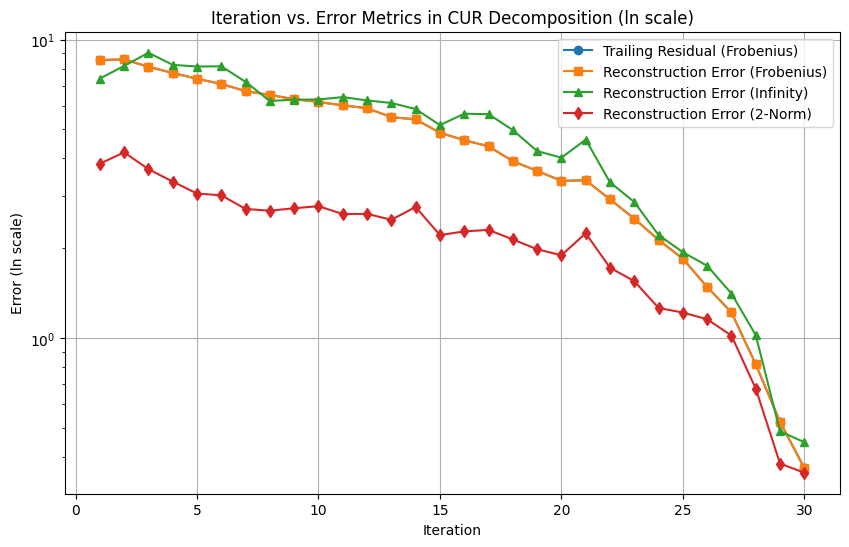

In [5]:
import numpy as np
import matplotlib.pyplot as plt


if __name__ == '__main__':
    # 產生一個 32x32 的測試矩陣
    A_test = generate_tensor(32, 32, 0.8)
    rank = 30
    print("A_test shape:", A_test.shape)

    # 建立 MCI_CUR 物件並執行 CUR 分解
    mci = MCI_CUR(A_test)
    mci.calculate(rank=rank)
    
    # 以最終 CUR 分解重構矩陣
    A_reconstructed = mci.C @ mci.U @ mci.R
    final_error = np.linalg.norm(A_test - A_reconstructed, ord='fro')
    print("\nFinal Reconstruction Error (Frobenius norm):", final_error)

    # 繪製各項誤差隨迭代變化圖（y 軸採對數尺度）
    iterations = list(range(1, len(mci.iteration_errors) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mci.iteration_errors, 'o-', label='Trailing Residual (Frobenius)')
    plt.plot(iterations, mci.recon_errors_fro, 's-', label='Reconstruction Error (Frobenius)')
    plt.plot(iterations, mci.recon_errors_inf, '^-', label='Reconstruction Error (Infinity)')
    plt.plot(iterations, mci.recon_errors_2, 'd-', label='Reconstruction Error (2-Norm)')
    plt.xlabel('Iteration')
    plt.ylabel('Error (ln scale)')
    plt.yscale('log')
    plt.title('Iteration vs. Error Metrics in CUR Decomposition (ln scale)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:


def tensor_train_CI(T):
    """
    使用矩陣交叉插值（CI）將 3x3x3 張量 T 分解為 Tensor Train (MPS) 形式
    """
    # Step 1: Reshape T to a 3x9 matrix (將 i 視為行，(jk) 視為列)
    T_mat = T.reshape(3, 9)
    
    # Step 2: 進行 SVD 分解
    U, S, Vh = np.linalg.svd(T_mat, full_matrices=False)
    
    # Step 3: 取 rank-2 近似（保留前 2 個特徵值）
    rank = 2
    U_trunc = U[:, :rank]   # (3x2)
    S_trunc = np.diag(S[:rank])   # (2x2)
    V_trunc = Vh[:rank, :]  # (2x9)

    # Step 4: 重新排列 V，使其形狀為 (2, 3, 3)
    V_tensor = V_trunc.reshape(rank, 3, 3)

    # Step 5: 產生 Tensor Train
    M1 = U_trunc   # (3x2)
    M2 = np.tensordot(S_trunc, V_tensor, axes=(1, 0))  # (2x3x3)

    return M1, M2

def tensor_train_prrLU(T):
    """
    使用部分秩揭示 LU 分解（prrLU）將 3x3x3 張量 T 分解為 Tensor Train (MPS) 形式
    """
    # Step 1: Reshape T to a 3x9 matrix (i 為行, (jk) 為列)
    T_mat = T.reshape(3, 9)
    
    # Step 2: 執行 LU 分解
    P, L, U = lu(T_mat)

    # Step 3: 取 rank-2 近似
    rank = 2
    L_trunc = L[:, :rank]  # (3x2)
    U_trunc = U[:rank, :]  # (2x9)

    # Step 4: 重新排列 U 使其形狀為 (2, 3, 3)
    U_tensor = U_trunc.reshape(rank, 3, 3)

    # Step 5: 產生 Tensor Train
    M1 = L_trunc   # (3x2)
    M2 = U_tensor  # (2x3x3)

    return M1, M2

# 測試
T = np.random.rand(3, 3, 3)
M1_CI, M2_CI = tensor_train_CI(T)
M1_prrLU, M2_prrLU = tensor_train_prrLU(T)

# 打印結果
print("Tensor Train (CI):")
print("M1 shape:", M1_CI.shape)
print("M2 shape:", M2_CI.shape)

print("\nTensor Train (prrLU):")
print("M1 shape:", M1_prrLU.shape)
print("M2 shape:", M2_prrLU.shape)

Tensor Train (CI):
M1 shape: (3, 2)
M2 shape: (2, 3, 3)

Tensor Train (prrLU):
M1 shape: (3, 2)
M2 shape: (2, 3, 3)
